<a href="https://colab.research.google.com/github/rubyvanrooyen/observation_planning/blob/main/callisto/Callisto_orbit_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import display
from ipywidgets import interact, widgets
from datetime import datetime, timedelta

import ephem
import numpy as np
import matplotlib.pyplotias plt
import matplotlib.dates as mdates

## Date of observation
Enter observation date: CCYY-MM-DD

In [ ]:
text_layout = {'width':'70px'}

year_lb = widgets.Text(value='Year', disabled=True, layout=text_layout)
mnth_lb = widgets.Text(value='Month', disabled=True, layout=text_layout)
day_lb = widgets.Text(value='Day', disabled=True, layout=text_layout)
labels = widgets.HBox([year_lb, mnth_lb, day_lb])

year = widgets.Text(value='2020', placeholder='CCYY', disabled=False, layout=text_layout)
mnth = widgets.Text(value='01', placeholder='MM', disabled=False, layout=text_layout)
day = widgets.Text(value='01', placeholder='DD', disabled=False, layout=text_layout)
date = widgets.HBox([year, mnth, day])

ui = widgets.VBox([labels, date])
display(ui)

In [ ]:
date_str = '{}/{:02d}/{:02d}'.format(year.value, int(mnth.value), int(day.value))
today = datetime.strptime(date_str, '%Y/%m/%d')

## Telescope location
MeerKAT array reference position set by default 


In [ ]:
text_layout = {'width':'100px'}

lat_lb = widgets.Text(value='Latitude', disabled=True, layout=text_layout)
lon_lb = widgets.Text(value='Longitude', disabled=True, layout=text_layout)
alt_lb = widgets.Text(value='Elevation [m]', disabled=True, layout=text_layout)
hrz_lb = widgets.Text(value='Horizon [deg]', disabled=True, layout=text_layout)
labels = widgets.HBox([lat_lb, lon_lb, alt_lb, hrz_lb])

lat = widgets.Text(value='-30:42:39.8', placeholder='latitude', disabled=False, layout=text_layout)
lon = widgets.Text(value='21:26:38.0', placeholder='longitude', disabled=False, layout=text_layout)
alt = widgets.Text(value='1086.6', placeholder='elevation', disabled=False, layout=text_layout)
hrz = widgets.Text(value='20.0', placeholder='horizon', disabled=False, layout=text_layout)
date = widgets.HBox([lat, lon, alt, hrz])

ui = widgets.VBox([labels, date])
display(ui)

In [ ]:
MKT = ephem.Observer()
MKT.lat = lat.value
MKT.lon = lon.value
MKT.elevation = float(alt.value)
MKT.horizon = ephem.degrees(hrz.value)
MKT.epoch = ephem.J2000
MKT.date = ephem.Date(today)

## Solar bodies of interest

In [ ]:
jupiter = ephem.Jupiter(MKT)
callisto = ephem.Callisto(MKT)
sun = ephem.Sun(MKT)
moon = ephem.Moon(MKT)

## Calisto-Jupiter orbit

Callisto has a 17 days orbital period

Position of moon relative to planet (measured in planet radii):    
x — offset +east or –west    
y — offset +south or –north    
z — offset +front or –behind    

Angular diameter:   

$d = 2D\tan(\delta/2)$    
with:
* $\delta$ the angular diameter ($\delta/2$ the angular radius),
* $D$ the distance to the object and
* $d$ the actual diameter of the object.

Angular radius equals half of the angular diameter with 
$\delta = 2 \arctan (\frac{d}{2D})$

Thus angular radius
$\rho = \arctan (\frac{d}{2D}) \approx \frac{d}{2D}$ assuming
$x \ll 1$: $\arctan x \approx x$

In [ ]:
# restore object date
MKT.date = ephem.Date(today)

In [ ]:
T = 16.689 # days

jupiter_lunar_separation = []
jupiter_solar_separation = []
jupiter_radius = []
jupiter_distance = []
jupiter_alt = []

time_range = []
callisto_x = []
callisto_y = []
callisto_z = []

for minute in np.arange(T * 24.*60.):
    now = ephem.Date(MKT.date).datetime()
    time_range.append(now)
    
    jupiter.compute(MKT)
    callisto.compute(MKT)
    moon.compute(MKT)
    
    jupiter_lunar_separation.append(np.degrees(ephem.separation(jupiter, moon)))
    jupiter_solar_separation.append(np.degrees(ephem.separation(jupiter, sun)))
    jupiter_radius.append(jupiter.radius)
    jupiter_distance.append(jupiter.earth_distance)
    jupiter_alt.append(np.degrees(jupiter.alt))
    
    callisto_x.append(callisto.x)
    callisto_y.append(callisto.y)
    callisto_z.append(callisto.z)
    
    MKT.date += ephem.minute

In [ ]:
phi = np.array(jupiter_radius)  # Radius as an angle
D = np.array(jupiter_distance)  # Distance to Earth [AU]
r = D*np.tan(phi)  # Jupiter radius [AU]
callisto_x = np.array(callisto_x)  # [frac of radius]
callisto_y = np.array(callisto_y)  # [frac of radius]
callisto_z = np.array(callisto_z)  # [frac of radius]

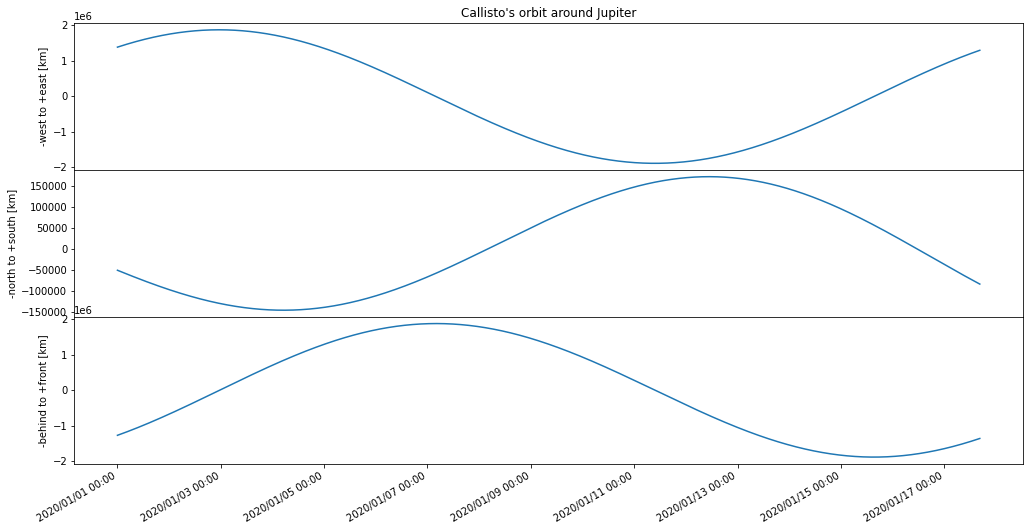

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1,
                       figsize=(17, 9),
                       facecolor='white')
fig.set_canvas(plt.gcf().canvas)
plt.subplots_adjust(hspace=0,wspace=0)

r_km = r * ephem.meters_per_au / 1e3  # [km]
ax[0].plot(time_range, callisto_x*r_km)
ax[0].set_ylabel('-west to +east [km]')
ax[0].set_title("Callisto's orbit around Jupiter")
ax[1].plot(time_range, callisto_y*r_km)
ax[1].set_ylabel('-north to +south [km]')
ax[2].plot(time_range, callisto_z*r_km)
ax[2].set_ylabel('-behind to +front [km]')

plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y/%m/%d %H:%M')
ax[-1].xaxis.set_major_formatter(myFmt)

plt.show()

Since we are looking at the orbital plane of the moons nearly edge-on, the moons seem to move along this line toward and away from the planet.
We can only measure the apparent distance of each moon from Jupiter, related to the moon’s distance from Jupiter. 

Apparent radius: $R_{app} = R \sin(\frac{2\pi}{T}t-T_0)$

In [ ]:
R = np.sqrt((r*callisto_x)**2 + (r*callisto_y)**2 + (r*callisto_z)**2)  # moon's distance [AU]
T_sec = T * (24*3600)
t = np.array([(the_datetime-MKT.date.datetime()).total_seconds() for the_datetime in time_range])  # [sec]
Rapp = R * np.sin (2*np.pi*(t/T_sec))  # moon's apparent distance [AU]
ang_sep_r = Rapp/D  # [rad]
ang_sep_r = np.degrees(ang_sep_r)*60  # angular distance [arcmin]

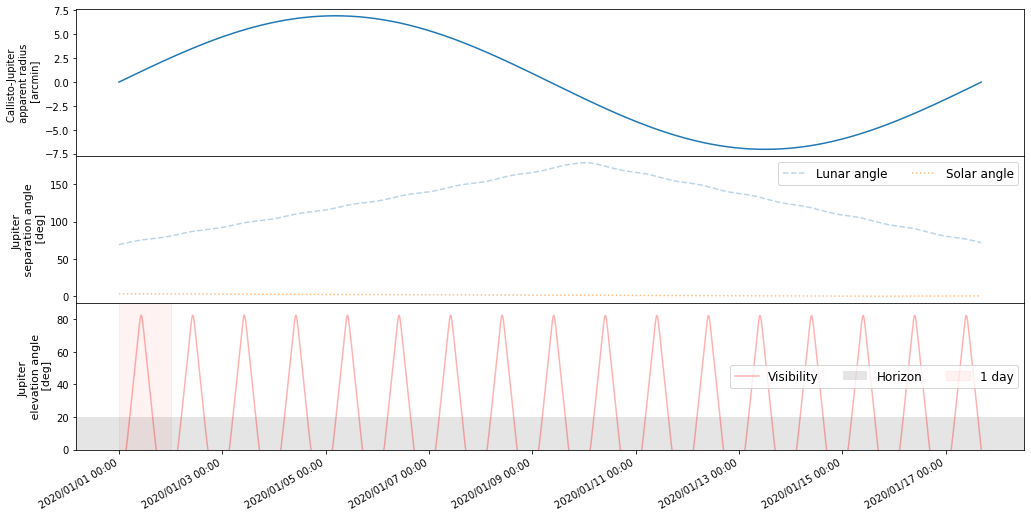

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1,
                       figsize=(17, 9),
                       facecolor='white')
fig.set_canvas(plt.gcf().canvas)
plt.subplots_adjust(hspace=0,wspace=0)


ax[0].plot(time_range, ang_sep_r)
ax[0].set_ylabel('Callisto-Jupiter \n apparent radius \n [arcmin]')

ax[1].plot(time_range, jupiter_lunar_separation, linestyle='--', alpha=0.3, label='Lunar angle')
ax[1].plot(time_range, jupiter_solar_separation, linestyle=':', alpha=0.5, label='Solar angle')
ax[1].set_ylabel('Jupiter \n separation angle \n [deg]', fontsize=11)
ax[1].legend(ncol=2, numpoints=1, fontsize=12)

ax[2].plot(time_range, jupiter_alt, 'r', alpha=0.3, label='Visibility')
ax[2].axhspan(0.0, np.degrees(MKT.horizon), facecolor="k", alpha=0.1, label='Horizon')
ax[2].axvspan(time_range[0], time_range[0] + timedelta(days=1), alpha=0.05, color='red', label='1 day')
ax[2].set_ylim(0, 90)
ax[2].set_ylabel('Jupiter \n elevation angle \n [deg]', fontsize=11)
ax[2].legend(ncol=3, numpoints=1, fontsize=12)

plt.gcf().autofmt_xdate()
myFmt = mdates.DateFormatter('%Y/%m/%d %H:%M')
ax[-1].xaxis.set_major_formatter(myFmt)

plt.show()